Tutorial from: https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [2]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [3]:

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [4]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [5]:

### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [6]:

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show() 

	 partial train loss (single batch): 0.252884
	 partial train loss (single batch): 0.245688
	 partial train loss (single batch): 0.240384
	 partial train loss (single batch): 0.236245
	 partial train loss (single batch): 0.231966
	 partial train loss (single batch): 0.228729
	 partial train loss (single batch): 0.225469
	 partial train loss (single batch): 0.221962
	 partial train loss (single batch): 0.219886
	 partial train loss (single batch): 0.217994
	 partial train loss (single batch): 0.215450
	 partial train loss (single batch): 0.213551
	 partial train loss (single batch): 0.211682
	 partial train loss (single batch): 0.209211
	 partial train loss (single batch): 0.207816
	 partial train loss (single batch): 0.205273
	 partial train loss (single batch): 0.203190
	 partial train loss (single batch): 0.201071
	 partial train loss (single batch): 0.199504
	 partial train loss (single batch): 0.197847
	 partial train loss (single batch): 0.196228
	 partial train loss (single batch

	 partial train loss (single batch): 0.068755
	 partial train loss (single batch): 0.067869
	 partial train loss (single batch): 0.066368
	 partial train loss (single batch): 0.066979
	 partial train loss (single batch): 0.066288
	 partial train loss (single batch): 0.065924
	 partial train loss (single batch): 0.067239
	 partial train loss (single batch): 0.065648

 EPOCH 1/30 	 train loss 0.12266264855861664 	 val loss 0.06541988253593445


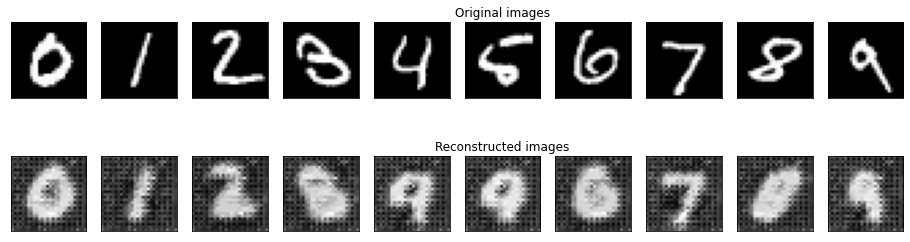

	 partial train loss (single batch): 0.066475
	 partial train loss (single batch): 0.065844
	 partial train loss (single batch): 0.066502
	 partial train loss (single batch): 0.065833
	 partial train loss (single batch): 0.065193
	 partial train loss (single batch): 0.065095
	 partial train loss (single batch): 0.063708
	 partial train loss (single batch): 0.065226
	 partial train loss (single batch): 0.064335
	 partial train loss (single batch): 0.063964
	 partial train loss (single batch): 0.063646
	 partial train loss (single batch): 0.064066
	 partial train loss (single batch): 0.062851
	 partial train loss (single batch): 0.063029
	 partial train loss (single batch): 0.062374
	 partial train loss (single batch): 0.062046
	 partial train loss (single batch): 0.062675
	 partial train loss (single batch): 0.061881
	 partial train loss (single batch): 0.062338
	 partial train loss (single batch): 0.061790
	 partial train loss (single batch): 0.061970
	 partial train loss (single batch

	 partial train loss (single batch): 0.047523
	 partial train loss (single batch): 0.047347
	 partial train loss (single batch): 0.045697
	 partial train loss (single batch): 0.046859
	 partial train loss (single batch): 0.046193
	 partial train loss (single batch): 0.046405
	 partial train loss (single batch): 0.047982
	 partial train loss (single batch): 0.046228

 EPOCH 2/30 	 train loss 0.05365144833922386 	 val loss 0.04667360335588455


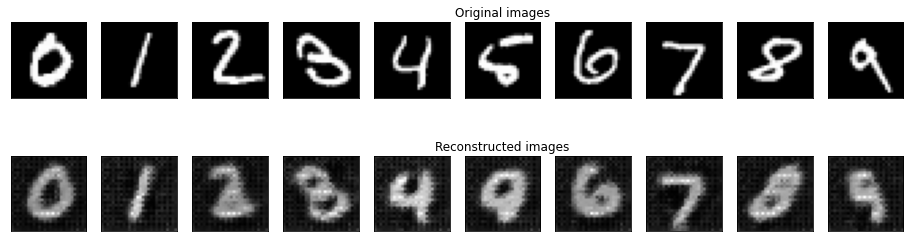

	 partial train loss (single batch): 0.047897
	 partial train loss (single batch): 0.047060
	 partial train loss (single batch): 0.047722
	 partial train loss (single batch): 0.047543
	 partial train loss (single batch): 0.046609
	 partial train loss (single batch): 0.047135
	 partial train loss (single batch): 0.045162
	 partial train loss (single batch): 0.047374
	 partial train loss (single batch): 0.046364
	 partial train loss (single batch): 0.046444
	 partial train loss (single batch): 0.046466
	 partial train loss (single batch): 0.046557
	 partial train loss (single batch): 0.046033
	 partial train loss (single batch): 0.046184
	 partial train loss (single batch): 0.045482
	 partial train loss (single batch): 0.044495
	 partial train loss (single batch): 0.045507
	 partial train loss (single batch): 0.045643
	 partial train loss (single batch): 0.045997
	 partial train loss (single batch): 0.045328
	 partial train loss (single batch): 0.045246
	 partial train loss (single batch

	 partial train loss (single batch): 0.038650
	 partial train loss (single batch): 0.038183
	 partial train loss (single batch): 0.038040
	 partial train loss (single batch): 0.036532
	 partial train loss (single batch): 0.037797
	 partial train loss (single batch): 0.037274
	 partial train loss (single batch): 0.037355
	 partial train loss (single batch): 0.039126
	 partial train loss (single batch): 0.036812

 EPOCH 3/30 	 train loss 0.04170854762196541 	 val loss 0.0376398041844368


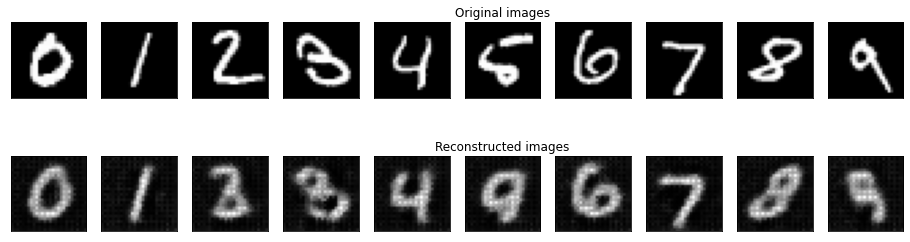

	 partial train loss (single batch): 0.039245
	 partial train loss (single batch): 0.037867
	 partial train loss (single batch): 0.038218
	 partial train loss (single batch): 0.038665
	 partial train loss (single batch): 0.037322
	 partial train loss (single batch): 0.038114
	 partial train loss (single batch): 0.036266
	 partial train loss (single batch): 0.038132
	 partial train loss (single batch): 0.037352
	 partial train loss (single batch): 0.037331
	 partial train loss (single batch): 0.037751
	 partial train loss (single batch): 0.037141
	 partial train loss (single batch): 0.037007
	 partial train loss (single batch): 0.036948
	 partial train loss (single batch): 0.036976
	 partial train loss (single batch): 0.035367
	 partial train loss (single batch): 0.036789
	 partial train loss (single batch): 0.037086
	 partial train loss (single batch): 0.037117
	 partial train loss (single batch): 0.036441
	 partial train loss (single batch): 0.036300
	 partial train loss (single batch

	 partial train loss (single batch): 0.034061
	 partial train loss (single batch): 0.033487
	 partial train loss (single batch): 0.033579
	 partial train loss (single batch): 0.031834
	 partial train loss (single batch): 0.033240
	 partial train loss (single batch): 0.033094
	 partial train loss (single batch): 0.033264
	 partial train loss (single batch): 0.034847
	 partial train loss (single batch): 0.032435

 EPOCH 4/30 	 train loss 0.034901607781648636 	 val loss 0.033375609666109085


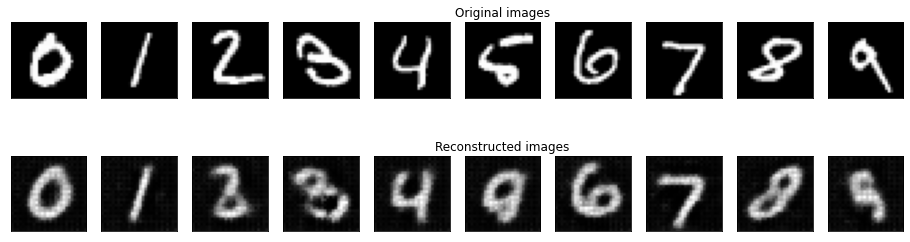

	 partial train loss (single batch): 0.035206
	 partial train loss (single batch): 0.033860
	 partial train loss (single batch): 0.033498
	 partial train loss (single batch): 0.034182
	 partial train loss (single batch): 0.032990
	 partial train loss (single batch): 0.033698
	 partial train loss (single batch): 0.032156
	 partial train loss (single batch): 0.033776
	 partial train loss (single batch): 0.032917
	 partial train loss (single batch): 0.033260
	 partial train loss (single batch): 0.033792
	 partial train loss (single batch): 0.032605
	 partial train loss (single batch): 0.032894
	 partial train loss (single batch): 0.032623
	 partial train loss (single batch): 0.032958
	 partial train loss (single batch): 0.031227
	 partial train loss (single batch): 0.032836
	 partial train loss (single batch): 0.033276
	 partial train loss (single batch): 0.033154
	 partial train loss (single batch): 0.032472
	 partial train loss (single batch): 0.032300
	 partial train loss (single batch

	 partial train loss (single batch): 0.032255
	 partial train loss (single batch): 0.031667
	 partial train loss (single batch): 0.031600
	 partial train loss (single batch): 0.029646
	 partial train loss (single batch): 0.031161
	 partial train loss (single batch): 0.031290
	 partial train loss (single batch): 0.031313
	 partial train loss (single batch): 0.032959
	 partial train loss (single batch): 0.030490

 EPOCH 5/30 	 train loss 0.03203212097287178 	 val loss 0.03139268234372139


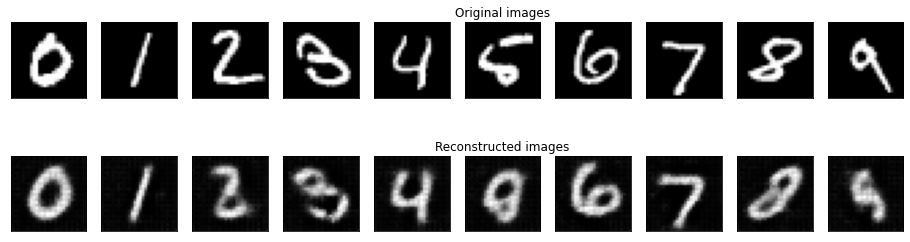

	 partial train loss (single batch): 0.033331
	 partial train loss (single batch): 0.032012
	 partial train loss (single batch): 0.031586
	 partial train loss (single batch): 0.032243
	 partial train loss (single batch): 0.031082
	 partial train loss (single batch): 0.031428
	 partial train loss (single batch): 0.030629
	 partial train loss (single batch): 0.032073
	 partial train loss (single batch): 0.031162
	 partial train loss (single batch): 0.031486
	 partial train loss (single batch): 0.032102
	 partial train loss (single batch): 0.030742
	 partial train loss (single batch): 0.031155
	 partial train loss (single batch): 0.030975
	 partial train loss (single batch): 0.031119
	 partial train loss (single batch): 0.029395
	 partial train loss (single batch): 0.031287
	 partial train loss (single batch): 0.031540
	 partial train loss (single batch): 0.031647
	 partial train loss (single batch): 0.030713
	 partial train loss (single batch): 0.030405
	 partial train loss (single batch

	 partial train loss (single batch): 0.030514
	 partial train loss (single batch): 0.030423
	 partial train loss (single batch): 0.028491
	 partial train loss (single batch): 0.030163
	 partial train loss (single batch): 0.030328
	 partial train loss (single batch): 0.030340
	 partial train loss (single batch): 0.031844
	 partial train loss (single batch): 0.029481

 EPOCH 6/30 	 train loss 0.030626550316810608 	 val loss 0.030318686738610268


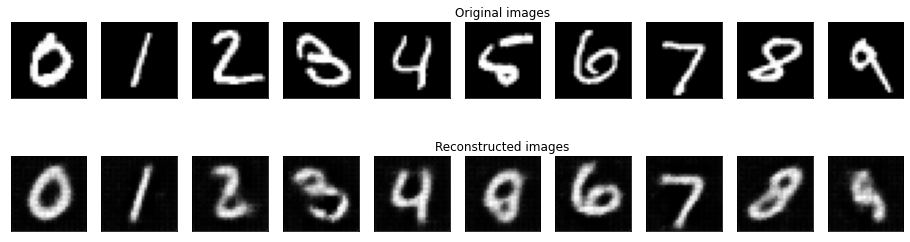

	 partial train loss (single batch): 0.032221
	 partial train loss (single batch): 0.031135
	 partial train loss (single batch): 0.030447
	 partial train loss (single batch): 0.031187
	 partial train loss (single batch): 0.030057
	 partial train loss (single batch): 0.030103
	 partial train loss (single batch): 0.029619
	 partial train loss (single batch): 0.031156
	 partial train loss (single batch): 0.030226
	 partial train loss (single batch): 0.030524
	 partial train loss (single batch): 0.031101
	 partial train loss (single batch): 0.029493
	 partial train loss (single batch): 0.030112
	 partial train loss (single batch): 0.029961
	 partial train loss (single batch): 0.030159
	 partial train loss (single batch): 0.028238
	 partial train loss (single batch): 0.030285
	 partial train loss (single batch): 0.030295
	 partial train loss (single batch): 0.030530
	 partial train loss (single batch): 0.029811
	 partial train loss (single batch): 0.029209
	 partial train loss (single batch

	 partial train loss (single batch): 0.030501
	 partial train loss (single batch): 0.029815
	 partial train loss (single batch): 0.029789
	 partial train loss (single batch): 0.027869
	 partial train loss (single batch): 0.029483
	 partial train loss (single batch): 0.029760
	 partial train loss (single batch): 0.029610
	 partial train loss (single batch): 0.031095
	 partial train loss (single batch): 0.028958

 EPOCH 7/30 	 train loss 0.029734281823039055 	 val loss 0.029619336128234863


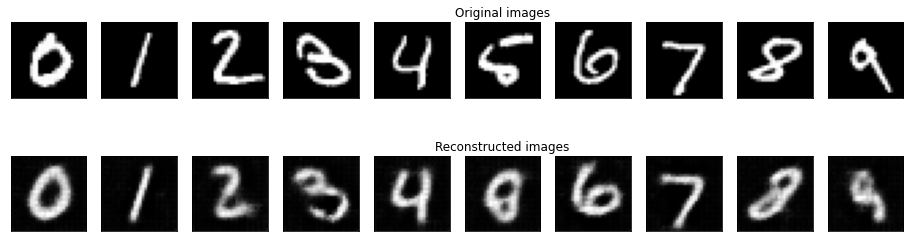

	 partial train loss (single batch): 0.031453
	 partial train loss (single batch): 0.030545
	 partial train loss (single batch): 0.029611
	 partial train loss (single batch): 0.030471
	 partial train loss (single batch): 0.029557
	 partial train loss (single batch): 0.029298
	 partial train loss (single batch): 0.028743
	 partial train loss (single batch): 0.030440
	 partial train loss (single batch): 0.029455
	 partial train loss (single batch): 0.029841
	 partial train loss (single batch): 0.030252
	 partial train loss (single batch): 0.028800
	 partial train loss (single batch): 0.029314
	 partial train loss (single batch): 0.029238
	 partial train loss (single batch): 0.029473
	 partial train loss (single batch): 0.027501
	 partial train loss (single batch): 0.029484
	 partial train loss (single batch): 0.029534
	 partial train loss (single batch): 0.029795
	 partial train loss (single batch): 0.029148
	 partial train loss (single batch): 0.028566
	 partial train loss (single batch

In [ ]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)